In [1]:
import warnings
warnings.filterwarnings("ignore")
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF
from utilsforecast.plotting import plot_series

df = AirPassengersDF

In [2]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string


In [3]:
season_length = 12 # Monthly data 


models = [AutoARIMA(season_length=season_length)]


In [4]:
sf = StatsForecast(df=df,
                   models=models,
                   freq='ME', 
                   n_jobs=-1)


In [5]:
sf.fit()

StatsForecast(models=[AutoARIMA])

In [6]:
arima_string(sf.fitted_[0,0].model_, padding=True)


'ARIMA(2,1,1)(0,1,0)[12]                   '

In [7]:
print(sf.predict(h = 4))

                  ds   AutoARIMA
unique_id                       
1.0       1961-01-31  447.979828
1.0       1961-02-28  423.806488
1.0       1961-03-31  453.501007
1.0       1961-04-30  496.713165


In [8]:
import statsmodels.api as sm

# Assuming your time series data is in a variable called 'data'

# Set up the model parameters
order = (2, 1, 1)  # Non-seasonal part (p, d, q)
seasonal_order = (0, 1, 0, 12)  # Seasonal part (P, D, Q, s)

# Create and fit the model
model = sm.tsa.statespace.SARIMAX(df['y'], 
                                  order=order, 
                                  seasonal_order=seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()

# Print a summary of the results
# print(results.summary())

# Make predictions
forecast = results.get_forecast(steps=12)  # Forecast next 12 periods

In [9]:
forecast = results.get_forecast(steps=4)
forecast.predicted_mean


144    444.352972
145    418.245359
146    446.278246
147    488.268196
Name: predicted_mean, dtype: float64

In [10]:
sf.predict(h = 12).reset_index()['AutoARIMA']
#make index start at t + 1
Y_df = sf.predict(h = 12).reset_index()['AutoARIMA']
Y_df.index = len(df) + Y_df.index 


In [11]:
Y_df

144    447.979828
145    423.806488
146    453.501007
147    496.713165
148    508.655090
149    572.366821
150    659.909668
151    644.322449
152    546.636536
153    499.875580
154    429.057434
155    471.195831
Name: AutoARIMA, dtype: float32

In [12]:
forecast.predicted_mean

144    444.352972
145    418.245359
146    446.278246
147    488.268196
Name: predicted_mean, dtype: float64

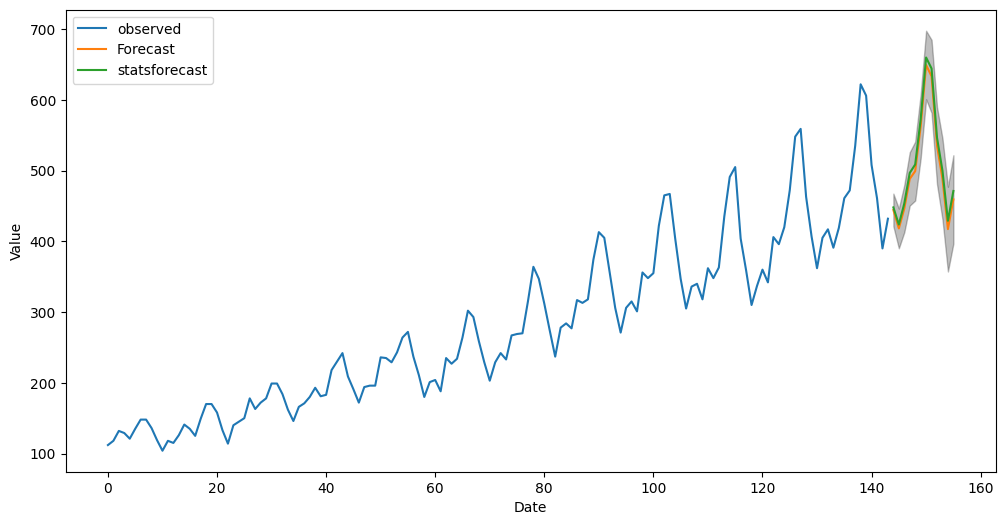

In [13]:
import matplotlib.pyplot as plt

# Get forecast with confidence intervals
forecast = results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Plot
ax = df['y'].plot(label='observed', figsize=(12, 6))
#plot statsforecast predictions
# ax = sf.predict(h = 12)['AutoARIMA'].plot(ax=ax, label='statsforecast')
forecast.predicted_mean.plot(ax=ax, label='Forecast')
Y_df.plot(ax=ax, label='statsforecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

def conformal_prediction_interval(model, X, y, alpha=0.1, n_splits=10):
    errors = []
    
    for _ in range(n_splits):
        # Split the data
        X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=0.2)
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Calculate errors on calibration set
        y_pred_cal = model.predict(X_cal)
        errors.extend(np.abs(y_cal - y_pred_cal))
    
    # Calculate the prediction interval
    q = np.quantile(errors, 1 - alpha)
    
    # Predict on the full dataset
    y_pred = model.predict(X)
    
    lower = y_pred - q
    upper = y_pred + q
    
    return lower, upper

In [15]:
ar1 = sf.fitted_[0,0].model_['coef']['ar1']
ar2 = sf.fitted_[0,0].model_['coef']['ar2']
ma1 = sf.fitted_[0,0].model_['coef']['ma1']
sigma2 = sf.fitted_[0,0].model_['sigma2']

In [20]:
# Create the model
model = sm.tsa.statespace.SARIMAX(df['y'],
                                  order=(2, 1, 1),
                                  seasonal_order=(0, 1, 0, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

# Fit the model with fixed parameters
results = model.fit(start_params=[ar1, ar2, ma1, sigma2**0.5], 
                    method='powell', 
                    disp=False,
                    maxiter=0)  # maxiter=0 prevents optimization

c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
forecast = results.get_forecast(steps=4)
forecast_mean = forecast.predicted_mean
print(forecast_mean)

144    437.383005
145    407.628249
146    432.355660
147    471.883227
Name: predicted_mean, dtype: float64


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -521.896
Date:                             Wed, 31 Jul 2024   AIC                           1051.792
Time:                                     21:59:51   BIC                           1063.232
Sample:                                          0   HQIC                          1056.440
                                             - 144                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5389      0.484      1.115      0.265      -0.409       1.487
ar.L2          0.1888      

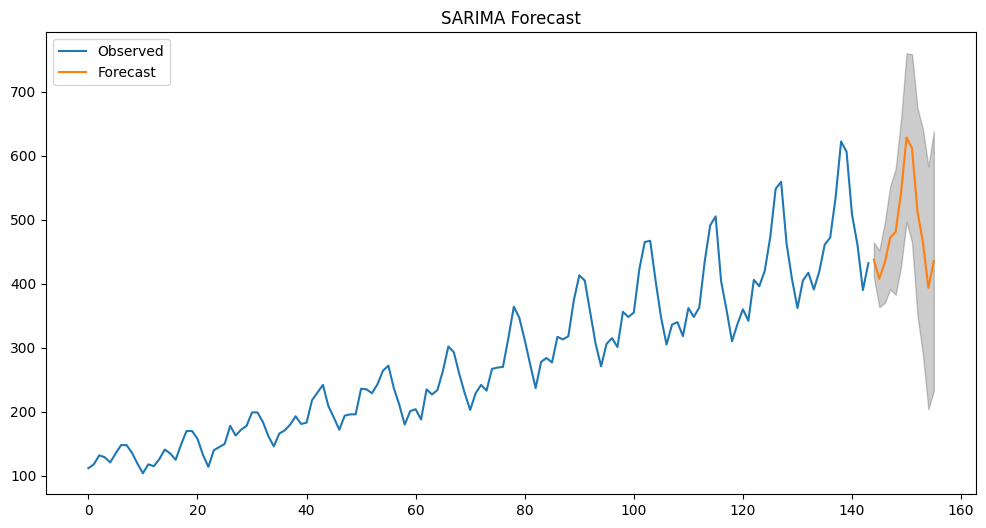

In [22]:
import statsmodels.api as sm
import numpy as np


# Print summary to compare with statsforecast results
print(results.summary())

# Compare log-likelihood, AIC, and BIC
print(f"Statsforecast Log-likelihood: {-506.04549828615}")
print(f"Statsmodels Log-likelihood: {results.llf}")
print(f"Statsforecast AIC: {1020.0909965723}")
print(f"Statsmodels AIC: {results.aic}")
print(f"Statsforecast BIC: {1031.5917858651046}")
print(f"Statsmodels BIC: {results.bic}")

# Generate forecast
forecast = results.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['y'], label='Observed')
plt.plot(forecast_mean, label='Forecast')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='k', alpha=0.2)
plt.legend()
plt.title('SARIMA Forecast')
plt.show()

In [23]:
methods = ['lbfgs', 'bfgs', 'newton', 'nm', 'cg', 'ncg', 'powell']
results_dict = {}

for method in methods:
    try:
        results = model.fit(start_params=[ar1, ar2, ma1, sigma2**0.5], 
                            method=method, 
                            disp=False)
        results_dict[method] = results
        print(f"{method.upper()} - AIC: {results.aic}, BIC: {results.bic}")
    except:
        print(f"{method.upper()} optimization failed")

LBFGS - AIC: 1003.7881042442551, BIC: 1015.2273538617018
BFGS - AIC: 1003.788104218353, BIC: 1015.2273538357997


c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


NEWTON - AIC: 7278.6798529029675, BIC: 7290.119102520414
NM - AIC: 1010.2995729468978, BIC: 1021.7388225643444
CG - AIC: 1143.2949690835014, BIC: 1154.734218700948
NCG optimization failed
POWELL - AIC: 1010.4221574115179, BIC: 1021.8614070289645


In [18]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])


dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(2, 1, 0, 0, 12, 1, 1)


In [19]:
result

{'coef': {'ar1': np.float64(0.5074421192184947),
  'ar2': np.float64(0.19286788825542367),
  'ma1': np.float64(-1.083761783162502)},
 'sigma2': np.float64(115.19442672818288),
 'var_coef': array([[ 0.00461227, -0.0044471 ,  0.        ],
        [-0.0044471 ,  0.00707351,  0.        ],
        [ 0.        ,  0.        ,  0.00763359]]),
 'mask': array([ True,  True,  True]),
 'loglik': np.float64(-506.04549828615),
 'aic': np.float64(1020.0909965723),
 'arma': (2, 1, 0, 0, 12, 1, 1),
 'residuals': array([ 6.46632151e-02,  3.35658432e-02,  3.38061473e-02,  2.25518531e-02,
         1.07538788e-02,  2.18258846e-02,  3.07928927e-02,  2.69275837e-02,
         1.25749149e-02, -4.85611771e-03, -1.87466608e-02, -7.77756688e-02,
        -4.26993532e-01,  4.23358063e+00,  2.40018357e+00, -1.92750329e+00,
        -2.31823839e+00,  8.47184332e+00,  1.06310959e+01,  4.12514021e+00,
         2.32510293e+00, -5.21741859e+00, -4.69772856e+00,  1.00100992e+01,
         1.16166713e+01, -7.40985649e-01,  1

In [25]:
best_results = model.fit(start_params=[ar1, ar2, ma1, sigma2**0.5], 
                         method='lbfgs',  # or 'bfgs'
                         disp=False)

print(best_results.pre

AttributeError: 'SARIMAXResults' object has no attribute 'mean_prediction_results'

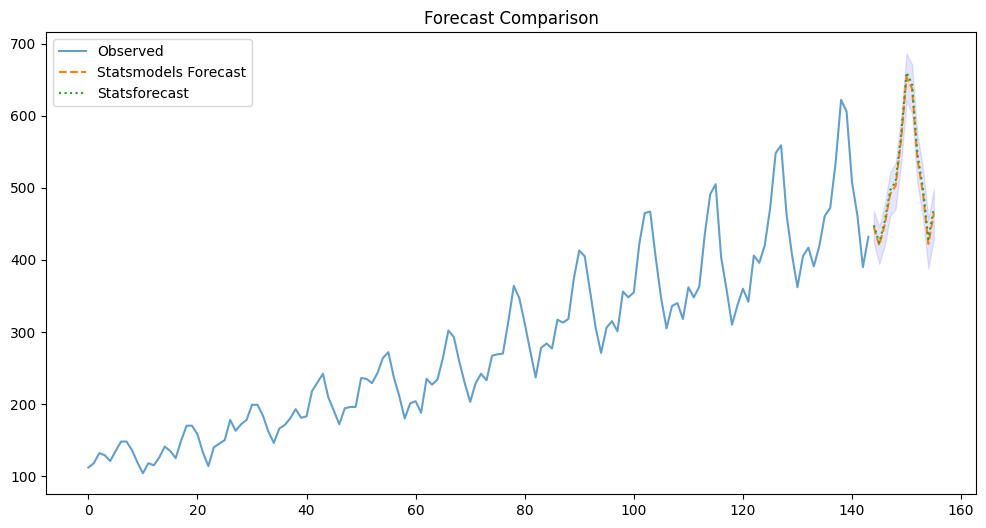

Statsmodels MAE: 30.873329845695462
Statsforecast MAE: 36.66832478841146


In [28]:
# Statsmodels forecast
forecast_sm = best_results.get_forecast(steps=12)
forecast_mean_sm = forecast_sm.predicted_mean
forecast_ci_sm = forecast_sm.conf_int()

# Assuming you have the statsforecast predictions
forecast_sf = sf.predict(h=12)['AutoARIMA']

plt.figure(figsize=(12, 6))
plt.plot(df['y'], label='Observed', alpha=0.7)
plt.plot(forecast_mean_sm, label='Statsmodels Forecast', linestyle='--')
plt.plot(Y_df, label='Statsforecast', linestyle=':')
plt.fill_between(forecast_ci_sm.index, 
                 forecast_ci_sm.iloc[:, 0], 
                 forecast_ci_sm.iloc[:, 1], 
                 color='blue', alpha=0.1)
plt.legend()
plt.title('Forecast Comparison')
plt.show()

# Calculate Mean Absolute Error for both forecasts
from sklearn.metrics import mean_absolute_error

last_12 = df['y'].iloc[-12:]
mae_sm = mean_absolute_error(last_12, forecast_mean_sm[-12:])
mae_sf = mean_absolute_error(last_12, forecast_sf)

print(f"Statsmodels MAE: {mae_sm}")
print(f"Statsforecast MAE: {mae_sf}")

c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


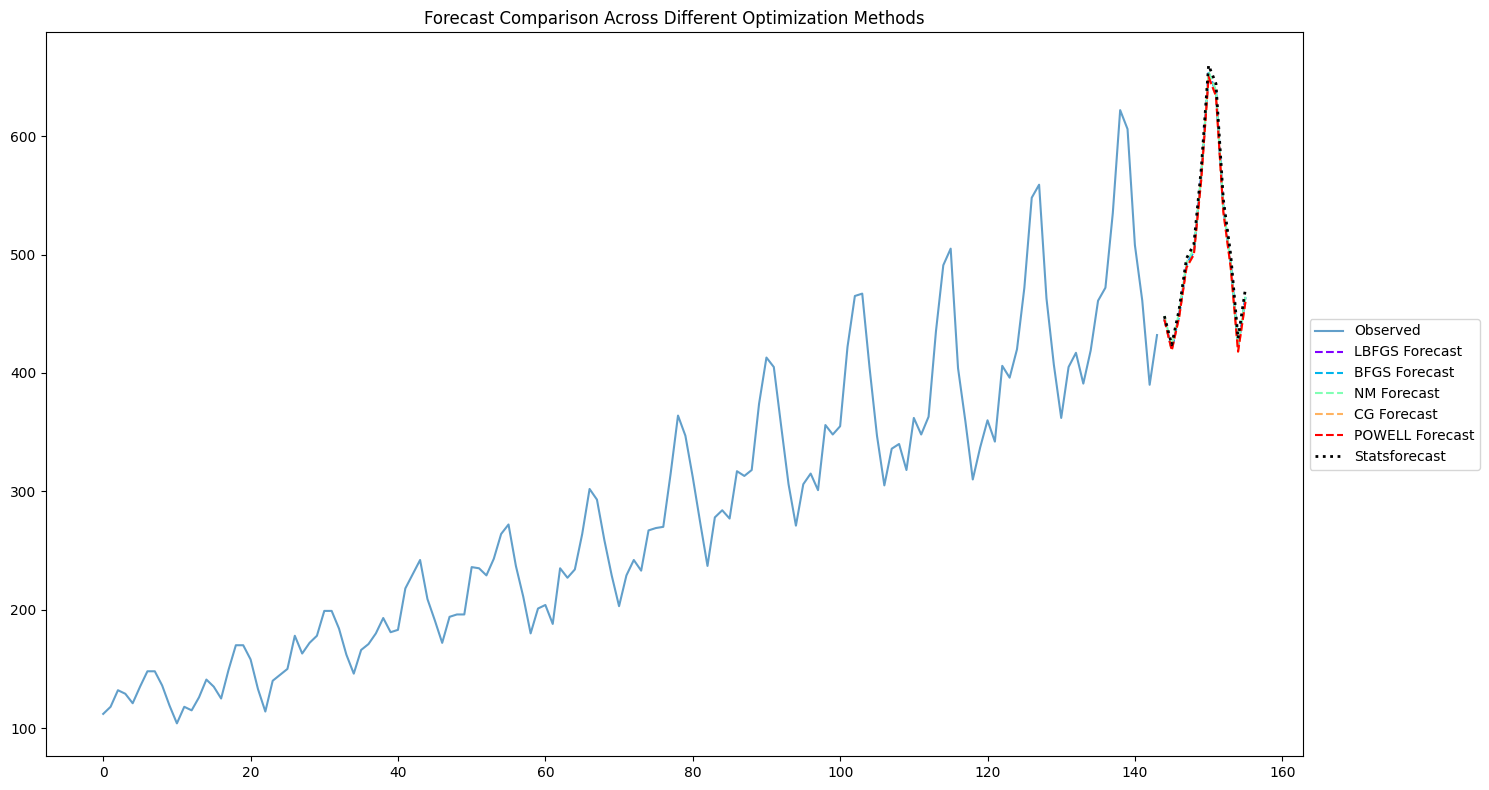

Mean Absolute Errors:
LBFGS: 30.873329845695462
BFGS: 30.873287720233353
NM: 32.26936745258625
CG: 27.891923169128585
POWELL: 28.09059624751693
Statsforecast MAE: 36.66832478841146


In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Define the methods to use
methods = ['lbfgs', 'bfgs', 'nm', 'cg', 'powell']

# Create a dictionary to store results
forecasts = {}
maes = {}

plt.figure(figsize=(15, 8))

# Plot observed data
plt.plot(df['y'], label='Observed', alpha=0.7)

# Colors for different methods
colors = plt.cm.rainbow(np.linspace(0, 1, len(methods)))

for method, color in zip(methods, colors):
    try:
        # Fit the model with each method
        results = model.fit(start_params=[ar1, ar2, ma1, sigma2**0.5], 
                            method=method, 
                            disp=False)
        
        # Generate forecast
        forecast = results.get_forecast(steps=12)
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int()
        
        # Store forecast
        forecasts[method] = forecast_mean
        
        # Plot forecast
        plt.plot(forecast_mean, label=f'{method.upper()} Forecast', linestyle='--', color=color)
        # plt.fill_between(forecast_ci.index, 
        #                  forecast_ci.iloc[:, 0], 
        #                  forecast_ci.iloc[:, 1], 
        #                  color=color, alpha=0.1)
        
        # Calculate MAE
        last_12 = df['y'].iloc[-12:]
        mae = mean_absolute_error(last_12, forecast_mean[-12:])
        maes[method] = mae
        
    except:
        print(f"{method.upper()} optimization failed")

# Plot statsforecast prediction
plt.plot(Y_df, label='Statsforecast', linestyle=':', color='black', linewidth=2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Forecast Comparison Across Different Optimization Methods')
plt.tight_layout()
plt.show()

# Print MAEs
print("Mean Absolute Errors:")
for method, mae in maes.items():
    print(f"{method.upper()}: {mae}")

print(f"Statsforecast MAE: {mean_absolute_error(last_12, forecast_sf)}")

In [29]:
Y_df


144    447.979828
145    423.806488
146    453.501007
147    496.713165
148    508.655090
149    572.366821
150    659.909668
151    644.322449
152    546.636536
153    499.875580
154    429.057434
155    471.195831
Name: AutoARIMA, dtype: float32

In [30]:
forecast_mean_sm

144    445.426463
145    420.054726
146    448.720181
147    491.241235
148    502.685356
149    566.054293
150    653.363122
151    637.621047
152    539.836605
153    493.016718
154    422.167225
155    464.292989
Name: predicted_mean, dtype: float64

In [45]:
train_size = int(len(df) * 0.9) 

In [46]:
train2 = df[:train_size]
train2

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
124,1.0,1959-05-31,420.0
125,1.0,1959-06-30,472.0
126,1.0,1959-07-31,548.0
127,1.0,1959-08-31,559.0


c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


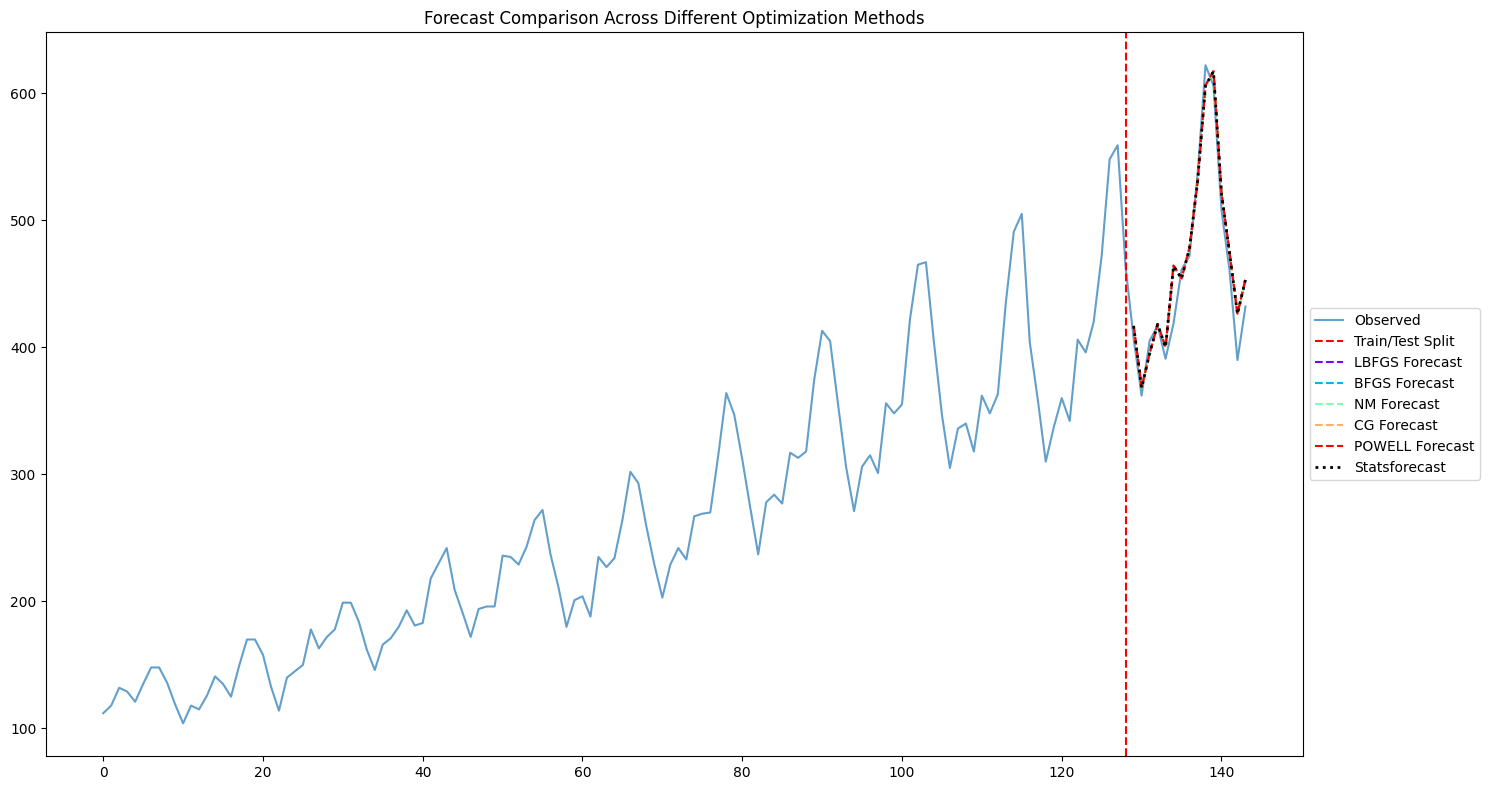

Mean Absolute Errors:
LBFGS: 14.124156778436392
BFGS: 14.138549565564468
NM: 13.70858213473379
CG: 14.148164106722628
POWELL: 14.118657308549256
Statsforecast MAE: 13.997410074869792


In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Define the methods to use
methods = ['lbfgs', 'bfgs', 'nm', 'cg', 'powell']

# Create dictionaries to store results
forecasts = {}
maes = {}

# Perform train-test split
 # Use 80% of data for training
train = df['y'][:train_size]
test = df['y'][train_size:]

plt.figure(figsize=(15, 8))

# Plot observed data
plt.plot(df['y'], label='Observed', alpha=0.7)
plt.axvline(x=train.index[-1], color='r', linestyle='--', label='Train/Test Split')

# Colors for different methods
colors = plt.cm.rainbow(np.linspace(0, 1, len(methods)))

for method, color in zip(methods, colors):
    try:
        # Create and fit the model with each method
        model = sm.tsa.statespace.SARIMAX(train,
                                          order=(2, 1, 1),
                                          seasonal_order=(0, 1, 0, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        
        results = model.fit(start_params=[ar1, ar2, ma1, sigma2**0.5], 
                            method=method, 
                            disp=False)
        
        # Generate forecast for the test period
        forecast = results.get_forecast(steps=len(test))
        forecast_mean = forecast.predicted_mean
        
        # Store forecast
        forecasts[method] = forecast_mean
        
        # Plot forecast
        plt.plot(forecast_mean, label=f'{method.upper()} Forecast', linestyle='--', color=color)
        
        # Calculate MAE
        mae = mean_absolute_error(test, forecast_mean)
        maes[method] = mae
        
    except Exception as e:
        print(f"{method.upper()} optimization failed: {str(e)}")

# Plot statsforecast prediction
sf = StatsForecast(df=train2,
                   models=models,
                   freq='ME', 
                   n_jobs=-1)
sf.fit()

sf_forecast = sf.predict(h=len(test)).reset_index()['AutoARIMA']

#make index start at t + 1
# Y_df = sf.predict(h = 12)['AutoARIMA']
sf_forecast.index = len(train) + sf_forecast.index 
plt.plot(sf_forecast, label='Statsforecast', linestyle=':', color='black', linewidth=2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Forecast Comparison Across Different Optimization Methods')
plt.tight_layout()
plt.show()

# Print MAEs
print("Mean Absolute Errors:")
for method, mae in maes.items():
    print(f"{method.upper()}: {mae}")

print(f"Statsforecast MAE: {mean_absolute_error(test, sf_forecast)}")